In [22]:
import tensorflow
import os
import shutil
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import joblib
import tensorflow_addons as tfa
import tempfile
import seaborn as sns

from os import listdir
from os.path import isfile, join
import math
from matplotlib.gridspec import GridSpec
import random



### Defining Model Structure

Here we define our model structure using data augmentation to augment are training dataset and then call this function to create a model.

In [23]:
image_height, image_width = 500, 500
batch_size = 256
epochs = 3

def create_model(image_height, image_width, cost_function):

    #Defining model
    model = keras.Sequential([
            keras.layers.Rescaling(1./255),
            keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
            keras.layers.MaxPool2D((2, 2)),
            keras.layers.Conv2D(32, (3, 3), activation='relu'),
            keras.layers.MaxPool2D((2, 2)),
            keras.layers.Conv2D(64, (3, 3), activation='relu'),
            keras.layers.MaxPool2D((2, 2)),
            keras.layers.Flatten(),
            keras.layers.Dense(512, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])
        
    #Compiling
    model.compile(loss='binary_crossentropy',
                        optimizer='adam', 
                        metrics=[cost_function])
    return model

def create_model_augmentation(image_height, image_width,  cost_function):

    # Defining data augmentation layer
    data_augmentation = keras.Sequential([
            keras.layers.RandomFlip("horizontal_and_vertical"),
            keras.layers.RandomRotation(0.5),
            keras.layers.RandomContrast(0.5)
            ])
    
    #Defining model
    model = keras.Sequential([
            data_augmentation,
            keras.layers.Rescaling(1./255),
            keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
            keras.layers.MaxPool2D((2, 2)),
            keras.layers.Conv2D(32, (3, 3), activation='relu'),
            keras.layers.MaxPool2D((2, 2)),
            keras.layers.Conv2D(64, (3, 3), activation='relu'),
            keras.layers.MaxPool2D((2, 2)),
            keras.layers.Flatten(),
            keras.layers.Dense(512, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])
        
    #Compiling
    model.compile(loss='binary_crossentropy',
                        optimizer='adam', 
                        metrics=[cost_function])
    return model

def plot_result(history):
    acc = history.history['F1Score']
    val_acc = history.history['val_F1Score']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

def plot_cm(labels, predictions, threshold):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

def make_predictions(model, val_ds, threshold):

    "Takes model + validation dataframe as input, returns predictions and labels"

    labels =  np.array([])
    predictions =  np.array([])
    # Iterating through batches and making predictions
    for x, y in val_ds:
        labels = np.concatenate([labels, y.numpy()])
        predictions = np.concatenate([predictions, 
                                        [i[0] for i in model.predict(x).tolist()]])

    # Converting to 1/0 depending on value relative to threshold
    predictions = [1 if i >= threshold else 0 for i in predictions]
    # Converting to int type
    predictions = np.array(predictions).astype(int)
    labels = np.array(labels).astype(int)

    return predictions, labels

def visualize_f1(histories):
    
    '''Takes dataframe containing keras training results, displays grid
    of val/train F1 Score over epoch'''
    
    graph_count = len(histories)
    rows = 1
    columns = int(math.ceil(graph_count/rows))
    fig = plt.figure(figsize=(10, 5))
    gs = GridSpec(nrows=rows, ncols=columns)
    keys = list(histories.keys())
    for model in range(len(histories.keys())):
        ax = fig.add_subplot(gs[int(math.floor(model/columns)), model%columns])
        ax.plot(histories[model]['Results'].index, histories[model]['Results']['f1_score'], label="Train f1")
        ax.plot(histories[model]['Results'].index, histories[model]['Results']['val_f1_score'], label="Val f1")
        plt.legend(loc="upper left")
        plt.grid(True)
        
        #Returning accuracy and formatting
        accuracy = round(histories[keys[model]]['Results']['val_f1_score'].max(),4)
        plt.title("Model {graph} f1 score {accuracy}".format(graph = model,
                                                 accuracy = accuracy))
        
    plt.tight_layout()
    plt.show()  
   
   
   

In [24]:
# Creating model for 500 x 500 image with a 0.5 classification threshold
my_model = create_model(image_height, image_width, 'accuracy')

### Loading Data
Reaing in the images from our directory

In [25]:
# Path to read data from
data_dir = './Data-Clean/'

# Defining train an validation splits using 80/20 split
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

print(type(train_ds))

Found 20637 files belonging to 2 classes.
Using 16510 files for training.
Found 20637 files belonging to 2 classes.
Using 4127 files for validation.
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


### Visualizing Data

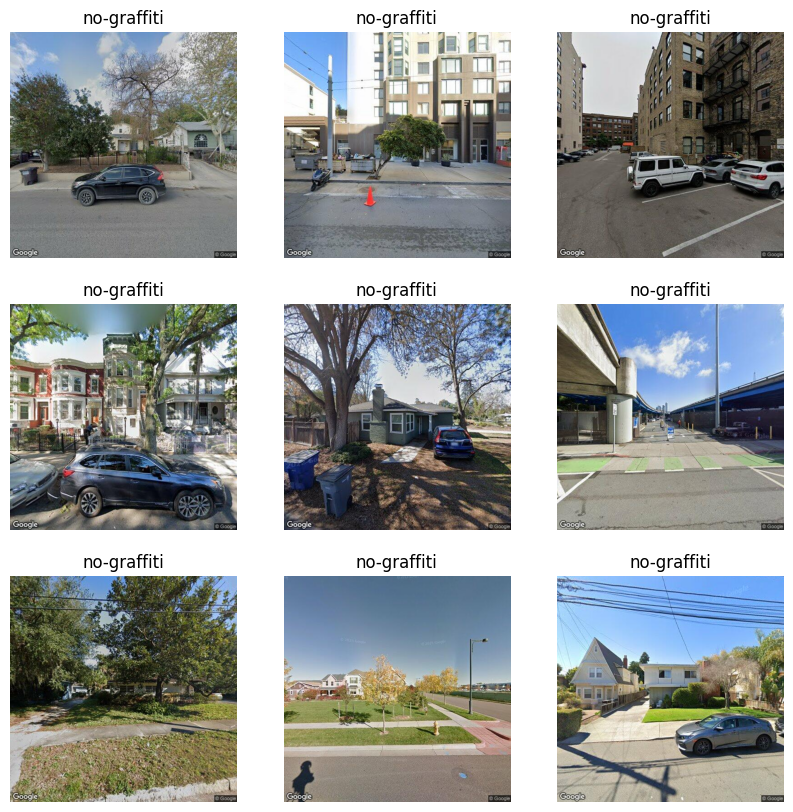

In [26]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Naive Approach - Modeling With Accuracy


In [27]:
path = os.getcwd() + '/models'
file_list = [f for f in listdir(path) if isfile(join(path, f))]
print(file_list)
# Initializing and compiling models
naive_model = create_model(image_height, image_width, 'accuracy')


# only training if the model doesnt already exist then train, otherwise load
if "naive_model.pkl" not in file_list:
  naive_history = naive_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
  )
  joblib.dump(naive_model, './models/naive_model.pkl')
  pd.DataFrame(naive_history.history).to_csv('./history/naive_history.csv')
else:
  naive_model =  joblib.load("./models/naive_model.pkl")


['high_threshold_model.pkl', 'low_threshold_model.pkl', 'naive_model.pkl', 'normal_threshold_model.pkl', 'weighted_augmented_medium_model.pkl', 'weighted_high_model.pkl', 'weighted_low_model.pkl', 'weighted_medium_model.pkl']


1/1 [==============================] - 0s 404ms/step
Legitimate Transactions Detected (True Negatives):  84
Legitimate Transactions Incorrectly Detected (False Positives):  57
Fraudulent Transactions Missed (False Negatives):  11
Fraudulent Transactions Detected (True Positives):  3975
Total Fraudulent Transactions:  3986


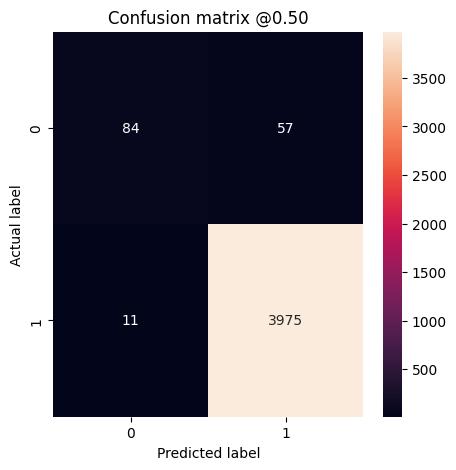

In [28]:
# Making predictions and plotting confusion matrix
test_predictions_baseline = my_model.predict(val_ds, batch_size=batch_size)
predictions, labels = make_predictions(naive_model, val_ds, 0.5)
plot_cm(labels, predictions, 0.5)

### Training Models Using F1 Score

Now that we have our training data and model defined we can now train it

In [29]:
low_threshold, medium_threshold, high_threshold = 0.25, 0.5, 0.75
# Initializing and compiling models
normal_threshold_model = create_model(image_height, image_width, 
                                      tfa.metrics.F1Score(num_classes = 2, average="micro"))

# only training if the model doesnt already exist then 
if "normal_threshold_model.pkl" not in file_list:
  history = normal_threshold_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
  )
  joblib.dump(normal_threshold_model, './normal_threshold_model.pkl')
  # Writing history to csv
  pd.DataFrame(history.history).to_csv('./history/medium_threshold_history.csv')
else:
  normal_threshold_model =  joblib.load("./models/normal_threshold_model.pkl")


### Evaluating Performance

In [30]:
# Making predictions with different thresholds
low_threshold_predictions, low_threshold_labels = make_predictions(normal_threshold_model, val_ds, 0.25)
medium_threshold_predictions, medium_threshold_labels = make_predictions(normal_threshold_model, val_ds, 0.5)
high_threshold_predictions, high_threshold_labels = make_predictions(normal_threshold_model, val_ds, 0.75)

1/1 [==============================] - 0s 336ms/step


### Creating Single Function to Display 3 Confusion Matrices

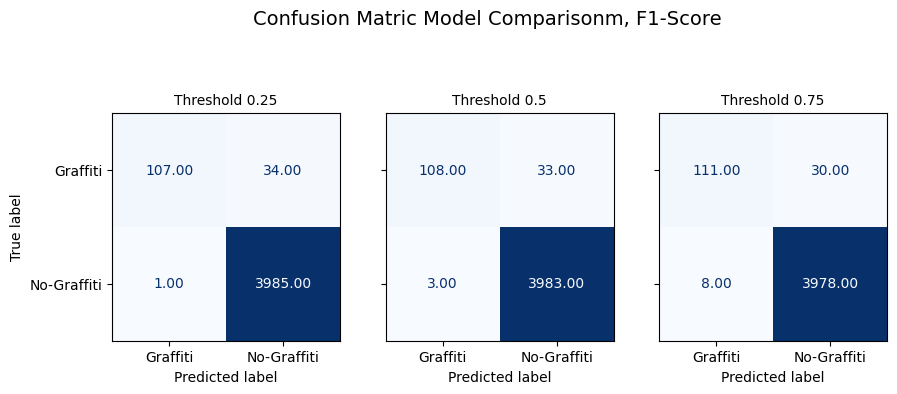

In [31]:
cmap = "Blues"
colorbar = False
display_labels = ["Graffiti", "No-Graffiti"]
values_format = ".2f"
f, axes = plt.subplots(1, 3, figsize=(10, 5))


# Creating confusion matrices
cm1 = confusion_matrix(low_threshold_labels, low_threshold_predictions > low_threshold)
cm2 = confusion_matrix(medium_threshold_labels, medium_threshold_predictions > medium_threshold)
cm3 = confusion_matrix(high_threshold_labels, high_threshold_predictions > high_threshold)

# Assembling into subplot
ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[0], colorbar=colorbar, values_format=values_format)

ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[1], colorbar=colorbar, values_format=values_format)

ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[2], colorbar=colorbar, values_format=values_format)

# Removing extra y axis lables
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[1].yaxis.set_ticklabels([ '', ''])
axes[2].yaxis.set_ticklabels([ '', ''])

# Adding Titles
title_size = 10
axes[0].set_title("Threshold {threshold}".format(threshold = low_threshold), size=title_size)
axes[1].set_title("Threshold {threshold}".format(threshold = medium_threshold), size=title_size)
axes[2].set_title("Threshold {threshold}".format(threshold = high_threshold), size=title_size)

f.suptitle("Confusion Matric Model Comparisonm, F1-Score", size=14, y=0.93)
plt.show()

### Comparing Training Across Models

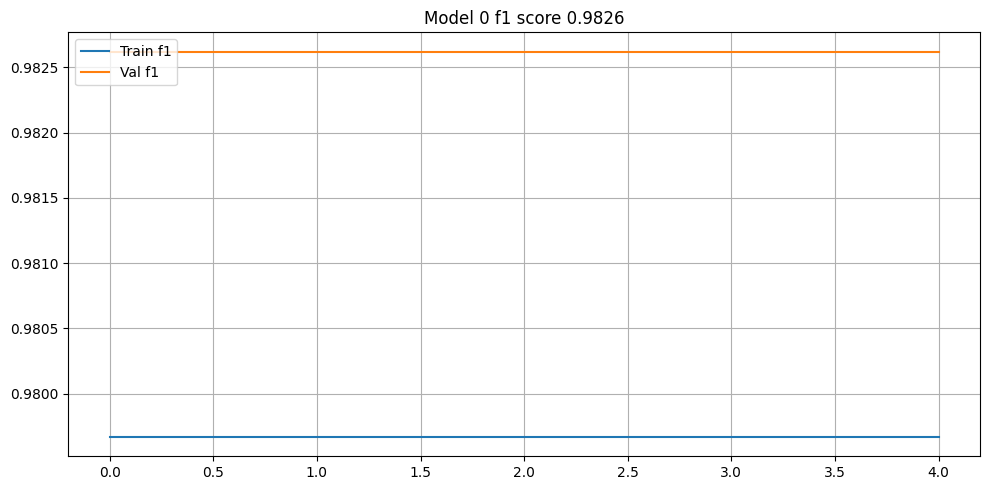

In [32]:
models = [ my_model]
history = [pd.read_csv('./history/medium_threshold_history.csv')]
histories = {}

# Aggregating model performance for comparison
for i in range(len(models)):
    histories[i] = {'Results' :pd.DataFrame(history[i]),
                            'Model' : history,
                            'End Score': history[i]['val_f1_score']}

#Viualizing training histories
visualize_f1(histories)

### Modeling with Adjusted Class Weights

In [33]:
# determing number of classes
total = len(labels)
no_graffiti_count = sum(labels)
graffiti_count = total - no_graffiti_count

print("Graffiti: ", graffiti_count,  " No Graffiti: ", no_graffiti_count)

# Adjusting class weights
graffiti_weight = (1 / graffiti_count) * (total / 2.0)
no_graffiti_weight = (1 / no_graffiti_count) * (total / 2.0)

class_weight = {0: graffiti_weight, 1: no_graffiti_weight}
print('Weight for class 0: {:.2f}'.format(graffiti_weight))
print('Weight for class 1: {:.2f}'.format(no_graffiti_weight))

Graffiti:  141  No Graffiti:  3986
Weight for class 0: 14.63
Weight for class 1: 0.52


In [34]:
# Initializing and compiling models with updated class weights
weighted_medium_model = create_model(image_height, image_width, 
                                   tfa.metrics.F1Score(num_classes = 2, average="micro"))
# only training if the model doesnt already exist then 
if "weighted_medium_model.pkl" not in file_list:
  weighted_medium_model_history = weighted_medium_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight = class_weight
  )
  joblib.dump(weighted_medium_model, './models/weighted_medium_model.pkl')
  pd.DataFrame(weighted_medium_model_history.history).to_csv('./history/weighted_medium_model_history.csv')
else:
  weighted_medium_model =  joblib.load("./models/weighted_medium_model.pkl")



In [35]:
# Making predictions with new models
low_weighted_predictions, low_weighted_labels = make_predictions(weighted_medium_model, val_ds, 0.25)
medium_weighted_predictions, medium_weighted_labels = make_predictions(weighted_medium_model, val_ds, 0.5)
high_weighted_predictions, high_weighted_labels = make_predictions(weighted_medium_model, val_ds, 0.75)

1/1 [==============================] - 0s 323ms/step


### Generating Confusion Matrices for weighted models

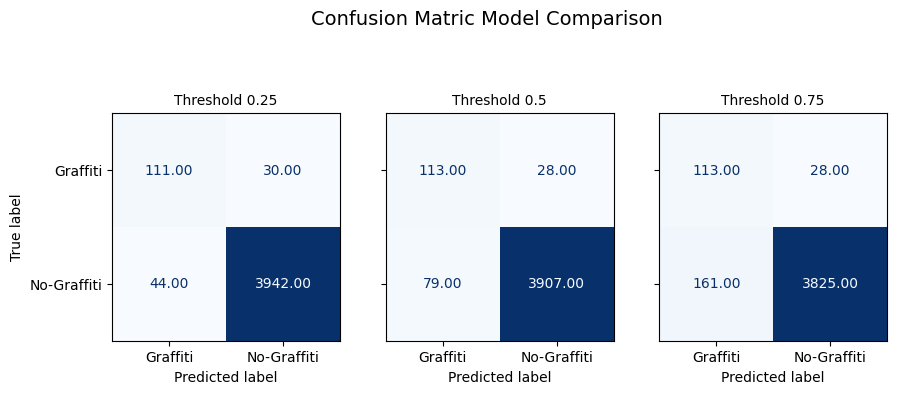

In [36]:
cmap = "Blues"
colorbar = False
display_labels = ["Graffiti", "No-Graffiti"]
values_format = ".2f"
f, axes = plt.subplots(1, 3, figsize=(10, 5))


# Creating confusion matrices
cm1 = confusion_matrix(low_weighted_labels, low_weighted_predictions > low_threshold)
cm2 = confusion_matrix(medium_weighted_labels, medium_weighted_predictions > medium_threshold)
cm3 = confusion_matrix(high_weighted_labels, high_weighted_predictions > high_threshold)

# Assembling into subplot
ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[0], colorbar=colorbar, values_format=values_format)

ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[1], colorbar=colorbar, values_format=values_format)

ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[2], colorbar=colorbar, values_format=values_format)

# Removing extra y axis lables
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[1].yaxis.set_ticklabels([ '', ''])
axes[2].yaxis.set_ticklabels([ '', ''])

# Adding Titles
title_size = 10
axes[0].set_title("Threshold {threshold}".format(threshold = low_threshold), size=title_size)
axes[1].set_title("Threshold {threshold}".format(threshold = medium_threshold), size=title_size)
axes[2].set_title("Threshold {threshold}".format(threshold = high_threshold), size=title_size)

f.suptitle("Confusion Matric Model Comparison, with Weighting", size=14, y=0.93)
plt.show()

### Training Performance of weighted models

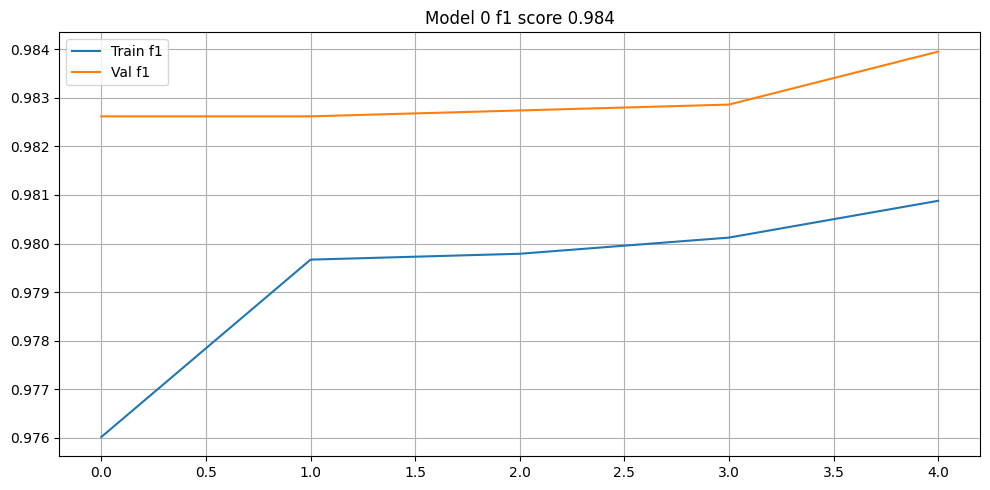

In [37]:
models = [my_model]
history = [pd.read_csv('./history/weighted_medium_model_history.csv')]
histories = {}

# Aggregating model performance for comparison
for i in range(len(models)):
    histories[i] = {'Results' :pd.DataFrame(history[i]),
                            'Model' : history,
                            'End Score': history[i]['val_f1_score']}

#Viualizing training histories
visualize_f1(histories)

### Retraining With F1 Score and Augmentation

In [38]:
# Initializing and compiling models with updated class weights
weighted_medium_aug_model = create_model_augmentation(image_height, image_width, 
                                   tfa.metrics.F1Score(num_classes = 2, average="micro"))
# only training if the model doesnt already exist then 
if "weighted_augmented_medium_model.pkl" not in file_list:
  weighted_medium_aug_model_history = weighted_medium_aug_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight = class_weight
  )
  joblib.dump(weighted_medium_aug_model, './models/weighted_augmented_medium_model.pkl')
  pd.DataFrame(weighted_medium_aug_model_history.history).to_csv('./history/weighted_medium_aug_model_history.csv')
else:
  weighted_medium_aug_model =  joblib.load("./models/weighted_augmented_medium_model.pkl")


In [39]:
# Making predictions with different thresholds
low_threshold_aug_predictions, low_threshold_aug_labels = make_predictions(weighted_medium_aug_model, val_ds, 0.25)
medium_threshold_aug_predictions, medium_threshold_aug_labels = make_predictions(weighted_medium_aug_model, val_ds, 0.5)
high_threshold_aug_predictions, high_threshold_aug_labels = make_predictions(weighted_medium_aug_model, val_ds, 0.75)

1/1 [==============================] - 0s 328ms/step


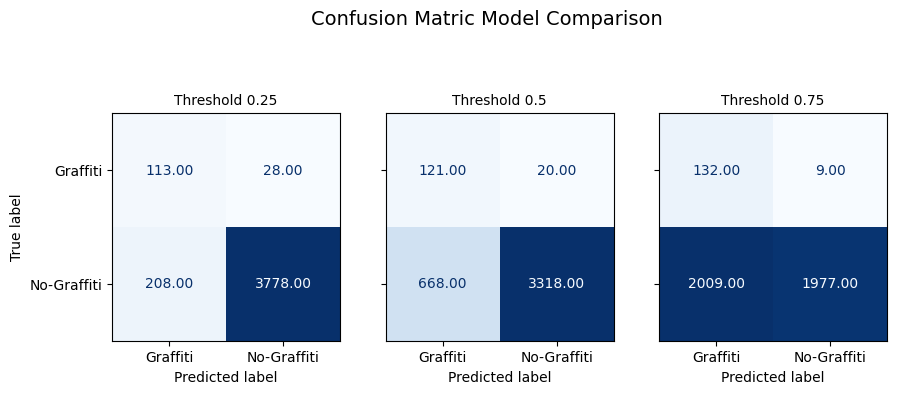

In [40]:
cmap = "Blues"
colorbar = False
display_labels = ["Graffiti", "No-Graffiti"]
values_format = ".2f"
f, axes = plt.subplots(1, 3, figsize=(10, 5))


# Creating confusion matrices
cm1 = confusion_matrix(low_threshold_aug_labels, low_threshold_aug_predictions > low_threshold)
cm2 = confusion_matrix(medium_threshold_aug_labels, medium_threshold_aug_predictions > medium_threshold)
cm3 = confusion_matrix(high_threshold_aug_labels, high_threshold_aug_predictions > high_threshold)

# Assembling into subplot
ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[0], colorbar=colorbar, values_format=values_format)

ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[1], colorbar=colorbar, values_format=values_format)

ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=display_labels).plot(
    include_values=True, cmap=cmap, ax=axes[2], colorbar=colorbar, values_format=values_format)

# Removing extra y axis lables
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[1].yaxis.set_ticklabels([ '', ''])
axes[2].yaxis.set_ticklabels([ '', ''])

# Adding Titles
title_size = 10
axes[0].set_title("Threshold {threshold}".format(threshold = low_threshold), size=title_size)
axes[1].set_title("Threshold {threshold}".format(threshold = medium_threshold), size=title_size)
axes[2].set_title("Threshold {threshold}".format(threshold = high_threshold), size=title_size)

f.suptitle("Confusion Matric Model Comparison, with Augmentation", size=14, y=0.93)
plt.show()